In [1]:
import pandas as pd
import numpy as np
# loading raw data
train_path = "../data/raw/train.csv"
test_path = "../data/raw/test.csv"
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
train.shape,test.shape

((891, 12), (418, 11))

In [3]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
train['Survived'].value_counts(normalize=True)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

Sex
male      577
female    314
Name: count, dtype: int64

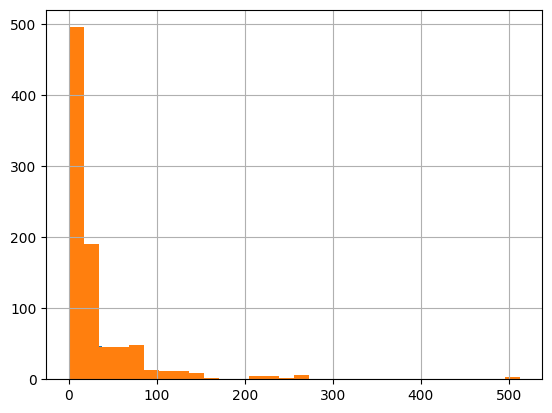

In [6]:
train['Age'].hist(bins=30)
train['Fare'].hist(bins=30)
train['Pclass'].value_counts()
train['Sex'].value_counts()

In [7]:
train.groupby('Sex')['Survived'].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [8]:
train.groupby('Pclass')['Survived'].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [9]:
train.groupby(['SibSp'])['Survived'].mean()

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

#Design Document 
1.Missing value handling 
Age (177 missing)
	•	Age has a meaningful relationship with Title (Mr, Miss, Mrs, etc.)
	•	Strategy: Impute Age using median Age within each Title group
Cabin (687 missing)
	•	Too many missing values to use Cabin directly
	•	Cabin contains deck information (first letter: A/B/C/D/E/F/G)
    	•	Strategy:
	•	Extract Deck = Cabin.str[0]
	•	Replace missing Deck with "Unknown"
	•	Drop Cabin afterwards
Embarked (2 missing)
	•	Very few missing values
	•	Strategy: Fill missing Embarked values with the most frequent category (‘S’)
#New engineering Features
2.1 Title (from Name)
	•	Extract Title via string split or regex
	•	Normalize rare titles into a single “Rare” category
	•	Why: Title captures gender, age distribution, and social status → strong predictor
2.2 Family Size 
    Formula 
    FamilySize = SibSp + Parch + 1
    	•	Why: Survival varies with family size (medium > small > large)
2.3 is alone 
IsAlone = 1 if FamilySize == 1 else 0
	•	Why: Alone passengers showed different behavior and survival probability
2.4 Fare per person 
    FarePerPerson = Fare / FamilySize
    	•	Why: More stable than raw Fare, better reflection of economic class
2.5 TicketGroupSize
    	•	Count how many passengers share the same Ticket
	•	Why: Indicates whether passengers traveled in groups → group survival behavior
2.6 Log Fare 
    LogFare = log1p(Fare)
    	•	Why: Fare is highly skewed; log-transform improves model stability
3. Categorical Encoding Strategy

These features will be one-hot encoded:
	•	Sex
	•	Pclass
	•	Embarked
	•	Title
	•	Deck

Binary feature (no encoding needed):
	•	IsAlone

4. Features to Drop 
These columns will be removed after extraction:
	•	PassengerId → No predictive value
	•	Name → Used only to extract Title
	•	Ticket → Replaced by TicketGroupSize
	•	Cabin → Replaced by Deck
5. Final Set of Model Features

After all engineering, the model will use:

Numerical Features
	•	Age (imputed)
	•	FarePerPerson
	•	LogFare
	•	FamilySize
	•	TicketGroupSize

Categorical Features
	•	Sex
	•	Pclass
	•	Embarked
	•	Title
	•	Deck
	•	IsAlone